In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lmfit import Model
import sys
import tqdm

sys.path.append('../my_funcs/')
from pipeline_main import pipeline
#from pipeline_stress import _fill_2Dhist
from pipeline_1D import *

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:04<00:00, 841.89it/s]


17603.99566460253
Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 8651.72it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5012.31it/s]


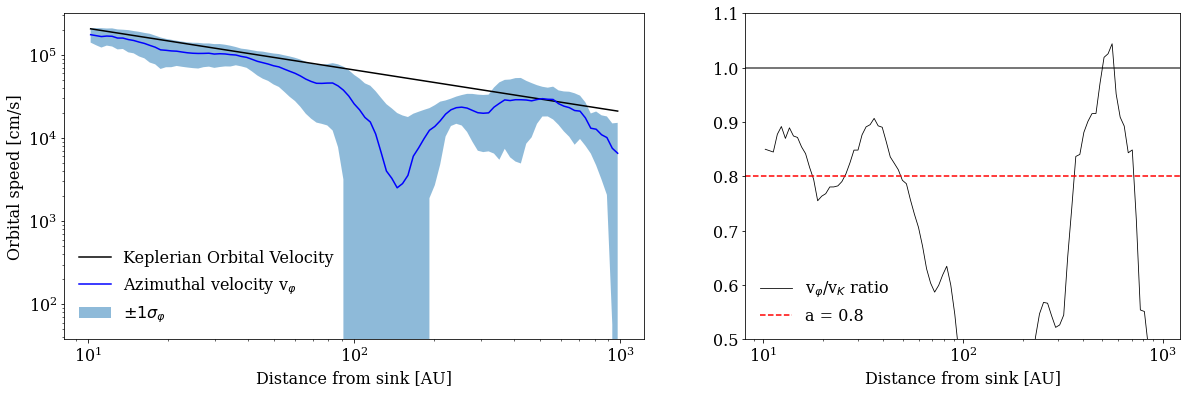

In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
print(data.time)
data.recalc_L(verbose = 1); 
data.calc_disksize(); data.calc_trans_xyz()

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 99/99 [00:01<00:00, 60.19it/s] 


Validating fit...


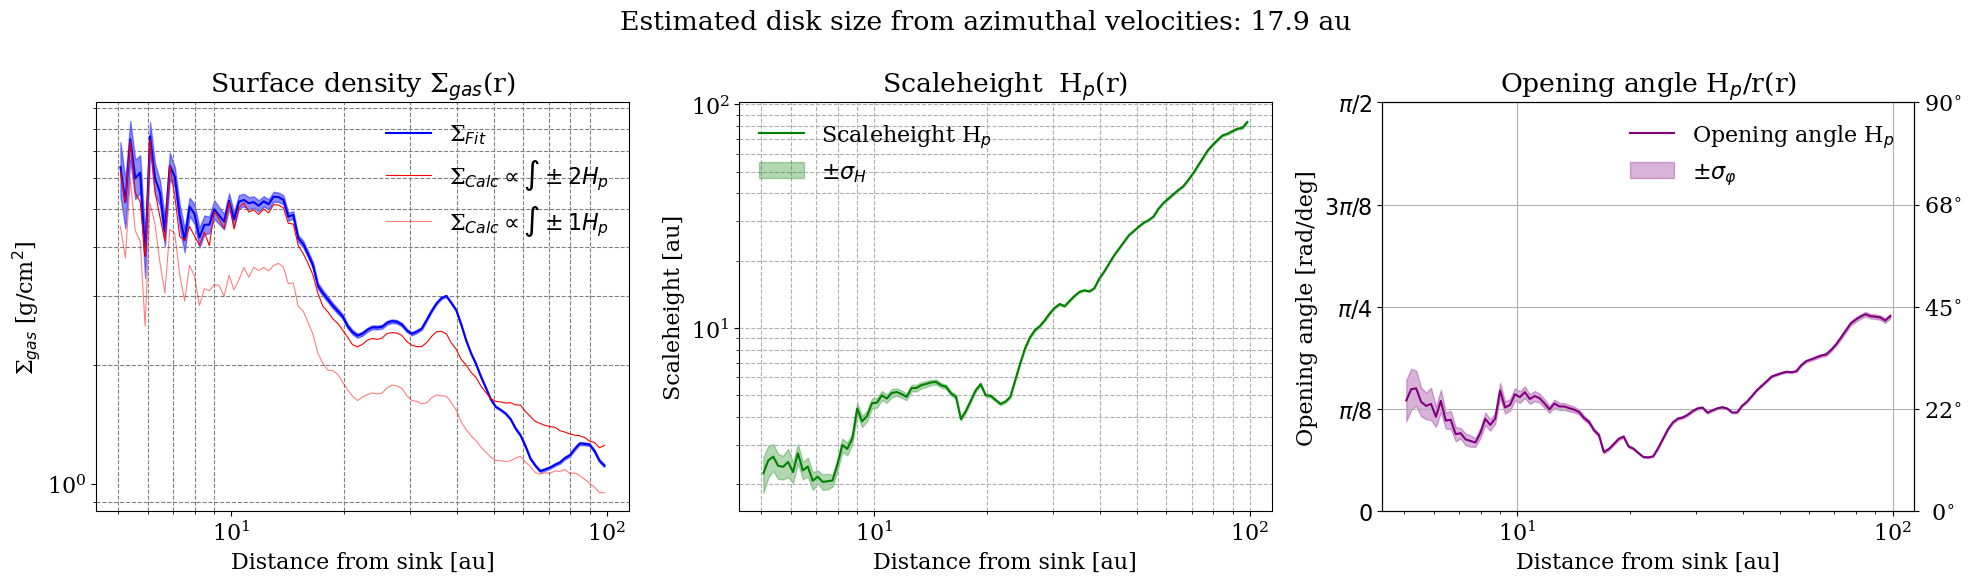

In [3]:
data.to_1D()

In [4]:
def Hp_func(x, Σ, H): return (Σ) / (np.sqrt(2 * np.pi) * H) * np.exp( - x**2 / (2 * H**2)) 

def fit_scaleheight(ρ, h, x0):
    model = Model(Hp_func)
    params = model.make_params(Σ = x0[0], H = x0[1])
    result = model.fit(ρ, x = h, params = params)
    fit_params = np.array(list(result.best_values.values()))
    fit_err = np.array([par.stderr for _, par in result.params.items()])
    fit_params[0] *= data.sn.cgs.au ; fit_err[0] *= data.sn.cgs.au

    return np.array([fit_params[0], fit_err[0]]), np.array([fit_params[1], fit_err[1]]) 

In [48]:
N_slices = 6
Σ_slice = np.zeros((N_slices, 2, data.Nr - 1))
H_slice = np.zeros_like(Σ_slice)
slice_size = 2*np.pi / N_slices

In [49]:
for s_i in tqdm.tqdm(range(N_slices)):
    densities = {key: [] for key in range(data.Nr - 1)}
    heights = {key: [] for key in range(data.Nr - 1)}

    for p in data.sorted_patches1D:
        nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        #to_extract = np.ones((16,16,16), dtype='bool')
        to_extract = (p.φ > s_i * slice_size) & (p.φ < (s_i+ 1) * slice_size) 
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 
        
        # Radial cut in the bins are saved for later since the cut will be used repeatedly
        bin_idx1D = np.digitize(p.cyl_R[to_extract].flatten(), bins = data.r_bins)                                   #Assigning each point to their repective bin 
        if (bin_idx1D == data.Nr).all() or (p.bin_idx1D == 0).all(): continue                                    #If the points are outside of the given bin the index is 0 or 25 (dependent on the length of radial bins)
        for bin in np.unique(p.bin_idx1D):
            if bin == 0 or bin == data.Nr: continue                                            
            h_idx = np.nonzero(abs(p.cyl_z[to_extract].flatten()[bin_idx1D == bin]) < 2 * data.r_1D[bin - 1])        # Now I make a cut only taking cells within 2 * the radial bins. I want the densities directory to be 0-indexet hence bin - 1
            if len(h_idx) == 0: continue                                             
            
            densities[bin - 1].extend(p.var('d')[to_extract].flatten()[bin_idx1D == bin][h_idx])
            heights[bin - 1].extend(p.cyl_z[to_extract].flatten()[bin_idx1D == bin][h_idx])

    for key in densities:
        densities[key] = np.array(densities[key]) * data.cgs_density
        heights[key] = np.array(heights[key]) * data.au_length

    x0 = np.array([1e3, 7])

    for i in range(data.Nr - 1):    
        Σ_slice[s_i, : ,i], H_slice[s_i, : ,i] = fit_scaleheight(ρ = densities[i], h = heights[i], x0 = x0)
        x0 = np.array([data.Σ_1D[i, 0], data.H_1D[i, 0]])
    

100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

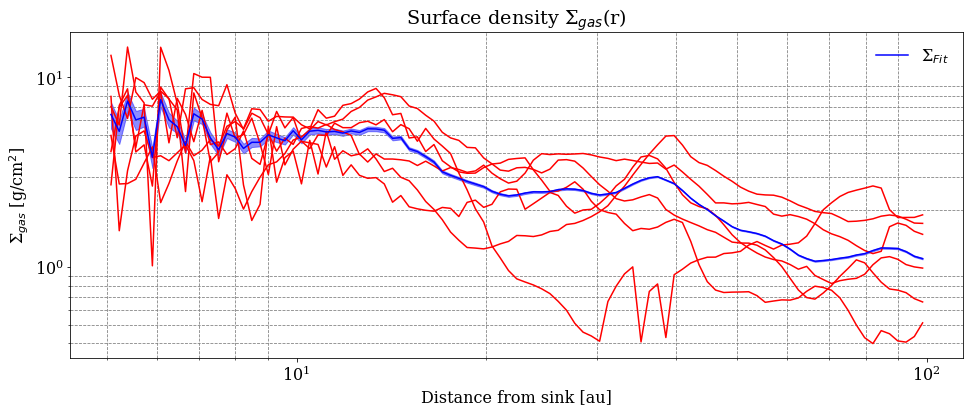

In [50]:
fig, axs = plt.subplots(figsize = (16,6))
axs.grid(which = 'minor', ls = '--', c = 'grey');

for i in range(N_slices):
    axs.loglog(data.r_1D * data.au_length, Σ_slice[i,0], color = 'red')
    #axs.fill_between(data.r_1D * data.au_length, Σ_slice[i,0] + Σ_slice[i,1], Σ_slice[i,0] - Σ_slice[i,1], alpha = 0.45, color = 'red')

axs.loglog(data.r_1D * data.au_length, data.Σ_1D[:,0], color = 'blue', label = 'Σ$_{Fit}$')
axs.fill_between(data.r_1D * data.au_length, data.Σ_1D[:,0] + data.Σ_1D[:,1], data.Σ_1D[:,0] - data.Σ_1D[:,1], alpha = 0.45, color = 'blue')


axs.set(ylabel = 'Σ$_{gas}$ [g/cm$^2$]', xlabel = 'Distance from sink [au]', title = 'Surface density Σ$_{gas}$(r)')

plt.legend(frameon = False)
plt.tight_layout